# Predictive model implementation

This notebook contains model preprocessing, training and evaluation.

In [1]:
import os
import sys

# Set-up notebook environment to include thoth_issue_predictor module.
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

module_path

'/home/tjanicek/thesis/thoth-issue-predictor'

In [2]:
from IPython.core.display import display
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from catboost import Pool, CatBoostClassifier
from datetime import datetime
from thoth_issue_predictor.preprocessing.grid_search import (
    grid_search_catboost,
    grid_search_scikit,
)
from thoth_issue_predictor.evaluation.metrics import Metrics
from thoth_issue_predictor.evaluation.model_evaluation import ModelEvaluation
from thoth_issue_predictor.preprocessing.preprocessing import Preprocessing

## Model Preprocessing

Model preprocessing is done in three stages:
 - function `prepare_df` unpacks data from archive file and creates dataframe with raw data.
 - class `Preprocessing` extracts relevant data
 - cell below drops duplicates
 - cell below splits dataset into test and train datasets

In [3]:
preprocessing = Preprocessing()
inspections_df = preprocessing.prepare_df()
issues_df, python_indexes = preprocessing.create_df()

In [4]:
# Drops duplicates and sets columns exit_code to correct representations.
issues_df["exit_code"] = inspections_df["exit_code"].astype("int")
issues_df = issues_df.loc[
    (issues_df.loc[:, issues_df.columns != "exit_code"] != 0).any(axis=1)
]
issues_df = issues_df.drop_duplicates()

In [5]:
python_indexes

['unknown', 'pypi-org', 'pypi-org-simple']

In [6]:
issue_x, exit_codes = issues_df.drop("exit_code", axis=1), issues_df["exit_code"]

X_train, X_test, y_train, y_test = train_test_split(
    issue_x, exit_codes, test_size=0.4, random_state=0
)

In [7]:
display(f"Length of DF is {len(issues_df)}")
issues_df.head(5)

'Length of DF is 247'

,python,tensorflow_major,tensorflow_minor,tensorflow_micro,tensorflow_index,absl-py_major,absl-py_minor,absl-py_micro,absl-py_index,astor_major,...,tensorboard-plugin-wit_index,packaging_major,packaging_minor,packaging_micro,packaging_index,pyparsing_major,pyparsing_minor,pyparsing_micro,pyparsing_index,exit_code
0,36,2,1,0,1,0,8,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,36,2,1,0,1,0,8,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,38,2,4,0,2,0,11,0,2,0,...,2,0,0,0,0,0,0,0,0,0
3,36,2,1,0,1,0,9,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,38,2,4,1,2,0,10,0,2,0,...,2,20,7,0,2,2,1,8,2,0


## Failed inspections

This section filters and visualizes failed software stacks from whole dataframe.

In [8]:
failed_inspections = issues_df[issues_df["exit_code"] == 1]
display(f"Number of failed inspections: {len(failed_inspections)}")
failed_inspections.head()

'Number of failed inspections: 37'

,python,tensorflow_major,tensorflow_minor,tensorflow_micro,tensorflow_index,absl-py_major,absl-py_minor,absl-py_micro,absl-py_index,astor_major,...,tensorboard-plugin-wit_index,packaging_major,packaging_minor,packaging_micro,packaging_index,pyparsing_major,pyparsing_minor,pyparsing_micro,pyparsing_index,exit_code
210,36,2,1,0,1,0,9,0,1,0,...,0,0,0,0,0,0,0,0,0,1
211,36,2,1,0,1,0,9,0,1,0,...,0,0,0,0,0,0,0,0,0,1
212,36,2,1,0,1,0,9,0,1,0,...,0,0,0,0,0,0,0,0,0,1
213,36,2,1,0,1,0,8,0,1,0,...,0,0,0,0,0,0,0,0,0,1
214,36,2,1,0,1,0,9,0,1,0,...,0,0,0,0,0,0,0,0,0,1


## Scikit CART model

This section contains implementation of Scikit DT model.
The implementation is done in stages:
 - get the best parameters using grid search
 - train classifier using train subset
 - create tree visualization and export it to `thoth_issue_predictor/visualizations/ThothIssuePredictor.pdf`
 - visualize the performance of model and save metric for comparisons

In [9]:
best_params = grid_search_scikit(X_train, y_train)
best_params

{'max_depth': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'splitter': 'best'}

In [10]:
clf = DecisionTreeClassifier(**best_params)

start = datetime.now()
clf.fit(X_train, y_train)
end = datetime.now()

In [11]:
feature_names = issue_x.columns
target_names = ["successful", "failed"]
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=feature_names,
    class_names=target_names,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph.render("visualizations/ThothIssuePredictor", format="pdf")

'visualizations/ThothIssuePredictor.pdf'

Train time: 0:00:00.002910
Prediction time: 0:00:00.003262
Number of errors: 0
AUC: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00        14

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

Confusion matrix for scikit
[[85  0]
 [ 0 14]]


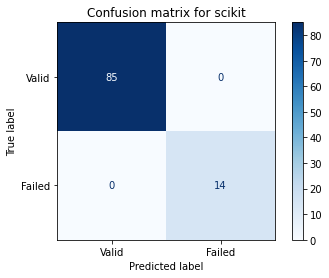

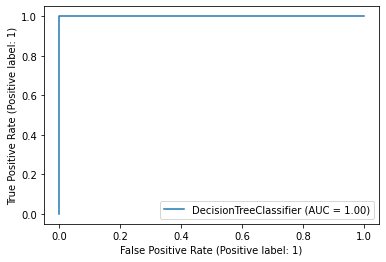

In [12]:
scikit_evaluation = ModelEvaluation("scikit", clf, end - start, X_test, y_test)
scikit_evaluation.predict_and_save()
scikit_evaluation.print()

## CatBoost GBDT model

This section contains implementation of CatBoost model.
The implementation is done in stages:
 - get the best parameters using grid search
 - train classifier using train subset
 - create tree visualization and export it to `thoth_issue_predictor/visualizations/ThothIssuePredictorBoost.pdf`
 - visualize the performance of model and save metric for comparisons

In [13]:
cat_features = [f for f in feature_names if "_index" in f]

issue_pool = Pool(issue_x, exit_codes, cat_features=cat_features)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [14]:
best_params = grid_search_catboost(train_pool)


bestTest = 1
bestIteration = 9

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 1
bestIteration = 9

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 1
bestIteration = 2

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 1
bestIteration = 2

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 1
bestIteration = 10

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 1
bestIteration = 10

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric paramete

In [15]:
clf = CatBoostClassifier(use_best_model=True, **best_params)
best_params

{'min_data_in_leaf': 3,
 'depth': 3,
 'iterations': 1000,
 'grow_policy': 'SymmetricTree',
 'verbose': False,
 'eval_metric': 'AUC',
 'loss_function': 'Logloss'}

In [16]:
start = datetime.now()
clf.fit(train_pool, eval_set=train_pool)
end = datetime.now()

In [17]:
dot_data = clf.plot_tree(0, pool=test_pool)
graph = graphviz.Source(dot_data)
graph.render("visualizations/ThothIssuePredictorBoost", format="pdf")

'visualizations/ThothIssuePredictorBoost.pdf'

Train time: 0:00:00.710153
Prediction time: 0:00:00.001347
Number of errors: 1
AUC: 0.9642857142857143
Accuracy: 0.98989898989899
Precision: 1.0
Recall: 0.9285714285714286
F1: 0.962962962962963
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        85
           1       1.00      0.93      0.96        14

    accuracy                           0.99        99
   macro avg       0.99      0.96      0.98        99
weighted avg       0.99      0.99      0.99        99

Confusion matrix for catboost
[[85  0]
 [ 1 13]]


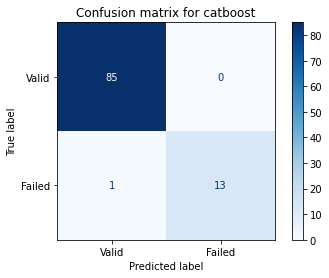

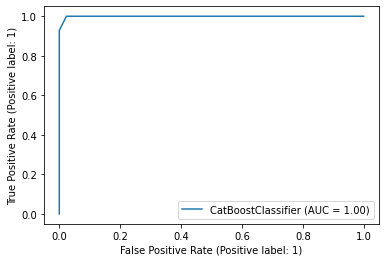

In [18]:
catboost_evaluation = ModelEvaluation("catboost", clf, end - start, test_pool, y_test)
catboost_evaluation.predict_and_save()
catboost_evaluation.print()

## Model Comparison

This section compares used models and visualizes the results.

'--------------------------------------------'

'Results for each category from best to worst'

'--------------------------------------------'

train_time:
1. scikit: 0:00:00.002910
2. catboost: 0:00:00.710153


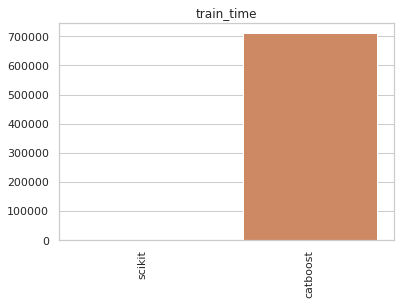

prediction_time:
1. catboost: 0:00:00.001347
2. scikit: 0:00:00.003262


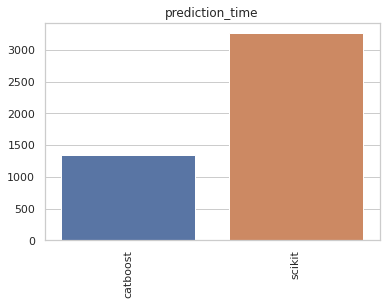

number_of_errors:
1. scikit: 0
2. catboost: 1


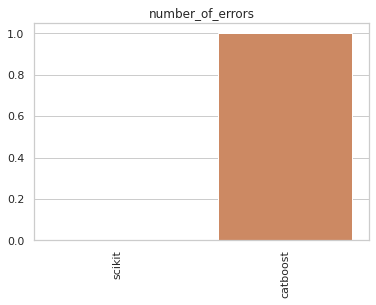

auc:
1. scikit: 1.0
2. catboost: 0.9642857142857143


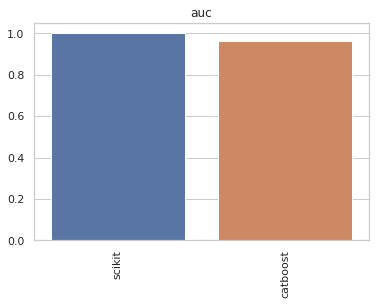

accuracy:
1. scikit: 1.0
2. catboost: 0.98989898989899


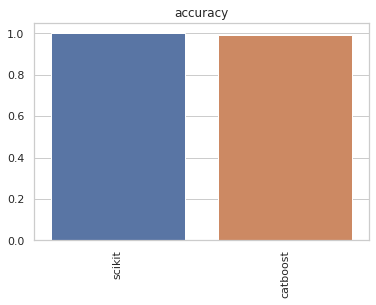

precision:
1. scikit: 1.0
2. catboost: 1.0


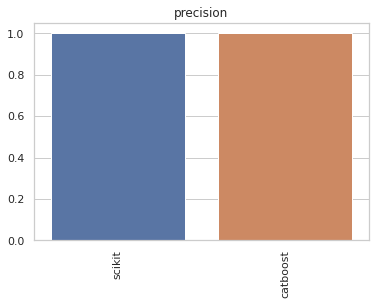

recall:
1. scikit: 1.0
2. catboost: 1.0


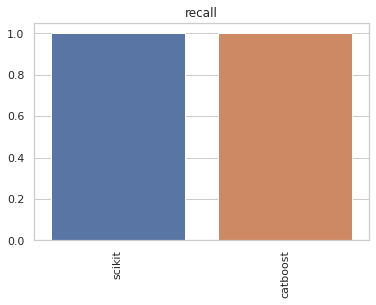

f1:
1. scikit: 1.0
2. catboost: 0.962962962962963


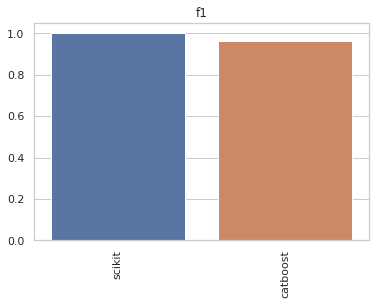

'-----------------------------'

'Best models for each category'

'-----------------------------'

train_time: scikit
prediction_time: catboost
number_of_errors: scikit
auc: scikit
accuracy: scikit
precision: scikit
recall: scikit
f1: scikit


In [19]:
metrics = Metrics([scikit_evaluation, catboost_evaluation])

metrics.sort_metrics()
display("--------------------------------------------")
display("Results for each category from best to worst")
display("--------------------------------------------")
metrics.print_results()

display("-----------------------------")
display("Best models for each category")
display("-----------------------------")
metrics.print_best()

### Analysis of visualized trees

Cell below filters dataset using conditions from Scikit DT visualization.
Main reason to doing so is trying to find the reason why certain software
stacks failed. Displayed dataframe show that all f
ailed software stack
share the same version of package Utllib3.

This [link](https://thoth-station.ninja/j/tf_21_urllib3.html) is a documentation of this issue
occurring during other resolutions.

In [20]:
urllib_cols = ["urllib3_major", "urllib3_minor", "urllib3_micro"]
chardet_minor_filter = issues_df["chardet_minor"] > 1.555
urllib_df = issues_df[chardet_minor_filter]
urllib_minor_filter = urllib_df["urllib3_minor"] <= 11.209
urllib_df = urllib_df[urllib_minor_filter]
urllib_micro_filter = urllib_df["urllib3_minor"] <= 8.654
urllib_df = urllib_df[urllib_micro_filter][urllib_cols]
urllib_df.drop_duplicates()

,urllib3_major,urllib3_minor,urllib3_micro
210,1,5,0
